# Lens distortions up to 2nd order

Let's consider a small region of the lens plane around $\vec\theta_0=(0,0)$. The lens equation including terms up to the second order si written as follows:
$$
\beta_i=\frac{\partial \beta_i}{\partial \theta_j}\theta_j+\frac{1}{2}\frac{\partial \beta_i}{\partial\theta_j\partial\theta_k}\theta_j\theta_k
$$
Each term in the equation is a sum over the indices $(j,k)\in (1,2)$. We omit the summatory for convenience.
Given that 
$$
\frac{\partial \beta_i}{\partial \theta_j}=A_{ij}
$$
the equation can also be re-written as
$$
\beta_i=A_{ij}\theta_j+\frac{1}{2}D_{ijk}\theta_j\theta_k \;,
$$
where we have introduced the matrix $D_{ijk}$.

As we have seen, the elements of D, $D_{ijk}$, are expressed as third derivatives of the lensing potential. These in turn can be written in terms of the flexions $F$ and $G$. After some math, we find that
$$
D_{111}=-2\gamma_{11}-\gamma_{22}=-\frac{1}{2}(3F_1+G_1)
$$
$$
D_{211}=D_{121}=D_{112}=-\gamma_{21}= -\frac{1}{2}(F_2+G_2)
$$
$$
D_{122}=D_{212}=D_{221}=-\gamma_{22}=-\frac{1}{2}(F_1-G_1)
$$
$$
D_{222}=2\gamma_{12}-\gamma_{21}=-\frac{1}{2}(3F_2-G_2)
$$

We can easily see that the two components of $\vec\beta$ are
$$
\beta_1=A_{11}\theta_1+A_{12}\theta_2+\frac{1}{2}D_{111}\theta_1^2+D_{121}\theta_1\theta_2+\frac{1}{2}D_{122}\theta_2^2
$$
and
$$
\beta_2=A_{21}\theta_1+A_{22}\theta_2+\frac{1}{2}D_{211}\theta_1^2+D_{212}\theta_1\theta_2+\frac{1}{2}D_{222}\theta_2^2
$$

Let's consider a circular source centered at $\vec{\beta}_0=(0,0)$. We assign to this source a surface brightness profile. For this exercise we can choose a general Sersic profile (Sersic 1963) in the form
$$
I_s(\beta)\propto\exp{-b_n[(\beta/r_e)^{1/n}-1]}
$$
where 
$$
b_n=1.992n - 0.3271
$$
for $0.5<n<8$, $r_e$ is the effective radius of the source and $n$ is the Sersic index. 

Since surface brightness is conserved,
$$
I(\vec\theta)=I_s(\vec\beta=\vec\theta-\vec\alpha(\vec\theta)) \;.
$$
This allows us to straightforwardly reconstruct the image of the source on the lens plane. In fact, the lens equation above allows to map the coordinates $\vec\theta$ into the coordinates $\vec{\beta}$ on the plane of the source. This is a ray-tracing procedure. We can indeed cover the lens plane with a grid of coordinates $\vec\theta$ and, once we know the corresponding coordinates $\vec\beta$, we can read-off the surface brighteness at $\vec\theta$ from the map of $I_s(\vec{\beta})$. 

Note that the lens equation above does not include any centroid shift in the image (i.e. the source and the image will be at the same position on the plane of the sky).


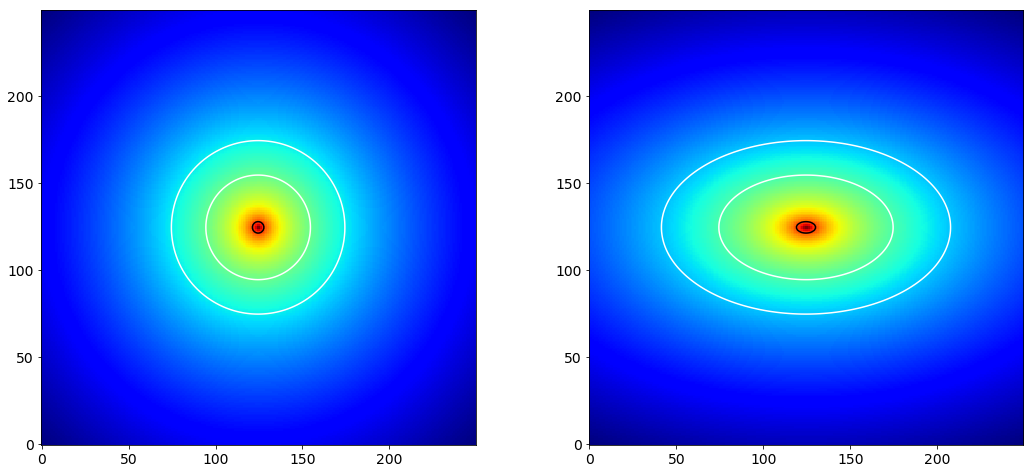

In [3]:
import numpy as np
from scipy.ndimage import map_coordinates
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm, SymLogNorm
%matplotlib inline

font = {'family' : 'DejaVu Sans',
        'weight' : 'normal',
        'size'   : 14}
import matplotlib
matplotlib.rc('font', **font)

plt.rcParams['image.cmap'] = 'jet'

class sersic(object):
    
    def __init__(self,side,N,**kwargs):
        
        if ('n' in kwargs):
            self.n=kwargs['n']
        else:
            self.n=4
            
        if ('re' in kwargs):
            self.re=kwargs['re']
        else:
            self.re=50.0
            
        if ('q' in kwargs):
            self.q=kwargs['q']
        else:
            self.q=1.0
            
        if ('pa' in kwargs):
            self.pa=kwargs['pa']
        else:
            self.pa=0.0
            
        self.N=N*2
        self.side=float(side)
        
        # define the pixel coordinates 
        pc=np.linspace(-side,side,self.N)
        X,Y = np.meshgrid(pc,pc)
        x = np.cos(self.pa)*X+np.sin(self.pa)*Y
        y = -np.sin(self.pa)*X+np.cos(self.pa)*Y
        r = np.sqrt((x/self.q)**2+y**2)
        
        # profile
        bn = 1.992*self.n - 0.3271
        self.unlensed_frame = np.exp(-bn*((r/self.re)**(1.0/self.n)-1.0))
        self.unlensed=self.mapCrop(self.unlensed_frame,self.N/2,self.N/2)
        
        self.X=X
        self.Y=Y

    def lens(self,**kwargs):
        if ('kappa' in kwargs):
            self.kappa = kwargs['kappa']
        else:
            self.kappa=0.0
            
        if ('gamma1' in kwargs):
            self.gamma1 = kwargs['gamma1']
        else:
            self.gamma1=0.0
            
        if ('gamma2' in kwargs):
            self.gamma2 = kwargs['gamma2']
        else:
            self.gamma2=0.0
            
        if ('g1' in kwargs):
            self.g1 = kwargs['g1']
        else:
            self.g1=0.0
        if ('g2' in kwargs):
            self.g2 = kwargs['g2']
        else:
            self.g2=0.0
            
        if ('f1' in kwargs):
            self.f1 = kwargs['f1']
        else:
            self.f1=0.0
        if ('f2' in kwargs):
            self.f2 = kwargs['f2']
        else:
            self.f2=0.0            

        a11=1.0-self.kappa-self.gamma1
        a22=1.0-self.kappa+self.gamma1
        a12=-self.gamma2
        a111=-0.5*(self.g1+3.0*self.f1)
        a222=-0.5*(3.0*self.f2-self.g2)
        a112=-0.5*(self.f2+self.g2)
        a221=-0.5*(self.f1-self.g1)

        b1 = a11*self.X + a12*self.Y + 0.5*a111*self.X**2 + \
            a112*self.X*self.Y + 0.5*a221*self.Y**2 #Create lensed coordinate x matrix
        b2 = a22*self.Y + a12*self.X + 0.5*a222*self.Y**2 + \
            a221*self.X*self.Y + 0.5*a112*self.X**2 #Create lensed coordinate y matrix

        #
        bb1=(b1+self.side)/(2.0*self.side/(self.N-1))
        bb2=(b2+self.side)/(2.0*self.side/(self.N-1))
        lensed_frame = map_coordinates(self.unlensed_frame, 
                                            [[bb2],[bb1]],order=1)
        
        lensed_frame=lensed_frame.reshape(self.N,self.N)
        self.lensed=self.mapCrop(lensed_frame,self.N/2,self.N/2)
        
        #Linear interpolation scheme
        #self.lensed_frame = self.__linearInterpolate(self.side,self.N,b1,b2,self.unlensed_frame)  
        

    def mapCrop(self,mappa,nx,ny):
        xmin=self.N/2-nx/2
        ymin=self.N/2-ny/2
        xmax=xmin+nx
        ymax=ymin+nx
        mappa=mappa[xmin:xmax,ymin:ymax]
        return(mappa)

kwargs={'n': 4, 're': 4.0, 'q': 1., 'pa': 0.0}
se=sersic(2.0,250,**kwargs)
se.lens(kappa=0.2, gamma1=0.2, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
fig,ax=plt.subplots(1,2,figsize=(18,8))
ax[0].imshow(se.unlensed,origin='lower',norm=LogNorm())
ax[0].contour(se.unlensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
        

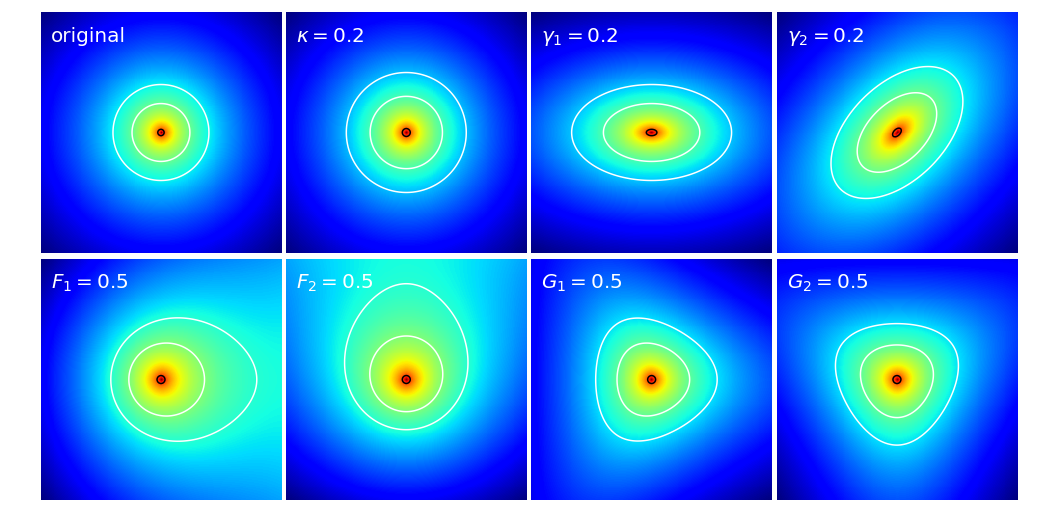

In [220]:
fig,ax=plt.subplots(2,4,figsize=(17.5,9))
se.lens(kappa=0.0, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
ax[0,0].imshow(se.unlensed,origin='lower',norm=LogNorm())
ax[0,0].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[0,0].text(10,220,'original',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
ax[0,1].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[0,1].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[0,1].text(10,220,'$\kappa=0.2$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.2, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
ax[0,2].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[0,2].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[0,2].text(10,220,'$\gamma_1=0.2$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.2, f1=0.0,f2=0.0,g1=0.0,g2=0.0)
ax[0,3].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[0,3].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[0,3].text(10,220,'$\gamma_2=0.2$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.5,f2=0.0,g1=0.0,g2=0.0)
ax[1,0].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1,0].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1,0].text(10,220,'$F_1=0.5$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.5,g1=0.0,g2=0.0)
ax[1,1].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1,1].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1,1].text(10,220,'$F_2=0.5$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.5,g2=0.0)
ax[1,2].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1,2].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1,2].text(10,220,'$G_1=0.5$',color='white',fontsize=20)

se.lens(kappa=0.2, gamma1=0.0, gamma2=0.0, f1=0.0,f2=0.0,g1=0.0,g2=0.5)
ax[1,3].imshow(se.lensed,origin='lower',norm=LogNorm())
ax[1,3].contour(se.lensed,
              levels=[se.lensed.max()*0.06,se.lensed.max()*0.1,
                      se.lensed.max()*0.5],
              colors=["white","white","black"])
ax[1,3].text(10,220,'$G_2=0.5$',color='white',fontsize=20)

for i in range(2):
    for j in range(4):
        ax[i,j].axis('off')
        
        
plt.subplots_adjust(wspace=0.02, hspace=0.02)
fig.savefig("flexion.png")